✅ Data Loaded: (10000, 12)
🔹 Default rate (Yes) in dataset: 35.07 %

📊 Classification Report:
              precision    recall  f1-score   support

  No Default       0.72      0.83      0.77      1623
     Default       0.55      0.39      0.46       877

    accuracy                           0.67      2500
   macro avg       0.63      0.61      0.61      2500
weighted avg       0.66      0.67      0.66      2500

✅ Accuracy: 67.4 %
✅ ROC-AUC: 0.697


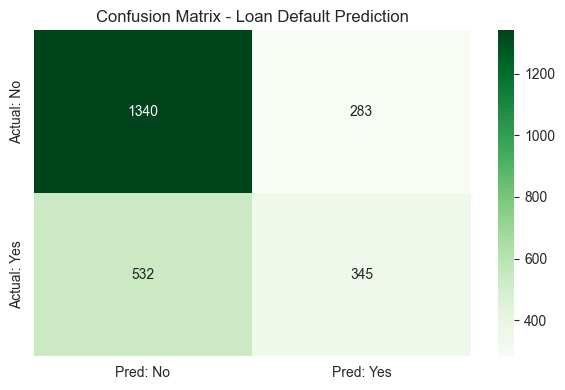

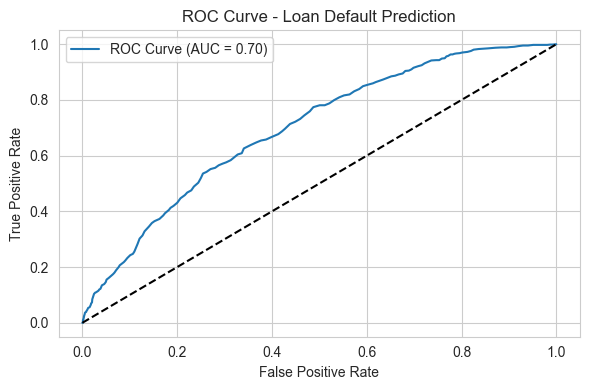

C:\Users\user\AppData\Local\Temp\ipykernel_25816\2482009496.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='viridis')


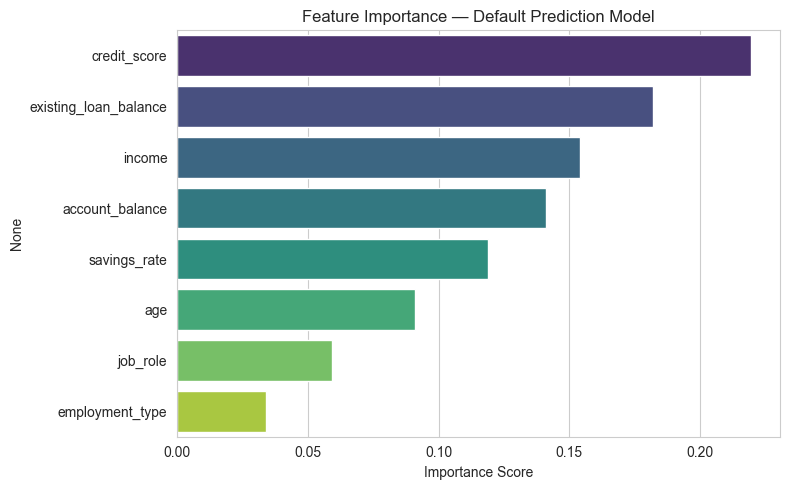


🎯 Top Predictive Features:
credit_score             0.219621
existing_loan_balance    0.182080
income                   0.153938
account_balance          0.141004
savings_rate             0.118898
dtype: float64

💾 Saved updated dataset with 'default' column (Yes/No) to Downloads!


In [1]:
# default_prediction_model.py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# ----------------- Setup -----------------
DOWNLOADS_DIR = os.path.join(os.path.expanduser("~"), "Downloads", "synthetic_data")
FILE_PATH = os.path.join(DOWNLOADS_DIR, "customers_hma_10000.csv")

customers = pd.read_csv(FILE_PATH)
print(f"✅ Data Loaded: {customers.shape}")

# ----------------- Step 1: Create Default Flag (Yes/No) -----------------
np.random.seed(42)

def default_probability(row):
    base_prob = 0.05  # baseline 5% default chance
    if row['credit_score'] < 600:
        base_prob += 0.25
    if row['income'] < 500000:
        base_prob += 0.15
    if row['savings_rate'] < 0.2:
        base_prob += 0.10
    if row['existing_loan_balance'] > 300000:
        base_prob += 0.20
    return "Yes" if np.random.rand() < base_prob else "No"

customers['default'] = customers.apply(default_probability, axis=1)

print("🔹 Default rate (Yes) in dataset:", round((customers['default'].eq("Yes").mean())*100, 2), "%")

# ----------------- Step 2: Prepare Data -----------------
# Encode 'Yes'/'No' for modeling
customers['default_flag'] = customers['default'].map({'No': 0, 'Yes': 1})

# Select features
features = ['age', 'income', 'credit_score', 'savings_rate',
            'existing_loan_balance', 'account_balance', 'employment_type', 'job_role']

data = customers[features + ['default_flag']].dropna()

# Encode categorical columns
label_enc = LabelEncoder()
for col in ['employment_type', 'job_role']:
    data[col] = label_enc.fit_transform(data[col])

# Split data
X = data.drop('default_flag', axis=1)
y = data['default_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scale numeric features
scaler = StandardScaler()
X_train[X.columns] = scaler.fit_transform(X_train)
X_test[X.columns] = scaler.transform(X_test)

# ----------------- Step 3: Train Model -----------------
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# ----------------- Step 4: Evaluate -----------------
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Default", "Default"]))

print("✅ Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("✅ ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))

# ----------------- Step 5: Confusion Matrix -----------------
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred: No', 'Pred: Yes'], yticklabels=['Actual: No', 'Actual: Yes'])
plt.title("Confusion Matrix - Loan Default Prediction")
plt.tight_layout()
plt.savefig(os.path.join(DOWNLOADS_DIR, "confusion_matrix_default_yes_no.png"), dpi=300)
plt.show()

# ----------------- Step 6: ROC Curve -----------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Loan Default Prediction')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(DOWNLOADS_DIR, "roc_curve_default_yes_no.png"), dpi=300)
plt.show()

# ----------------- Step 7: Feature Importance -----------------
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title("Feature Importance — Default Prediction Model")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig(os.path.join(DOWNLOADS_DIR, "feature_importance_default_yes_no.png"), dpi=300)
plt.show()

print("\n🎯 Top Predictive Features:")
print(importances.head())

# ----------------- Step 8: Save Enhanced Dataset -----------------
customers_out = customers.copy()
customers_out.to_csv(os.path.join(DOWNLOADS_DIR, "customers_with_default_yes_no.csv"), index=False)
print("\n💾 Saved updated dataset with 'default' column (Yes/No) to Downloads!")
